In [1]:
import sys
import itertools
import numpy as np
from tqdm.notebook import tqdm
from importlib import reload
import matplotlib as mpl
import mpltern
import itertools
import torch
import time

from scipy.spatial import ConvexHull

# CUSTOM LIBRARY
import flory.flory as flory # This reads __init__ in which basic classes are specified. 
import alps.graph as graph
import alps.evolution as evo
import alps.convex_hull as ch
import alps.vector as vec
import alps.geometry as geom

C:\Users\tm688\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


__fontsize__ = 12
__figsize__ = (4, 4)
cmap = 'magma'

# See all available arguments in matplotlibrc
params = {'figure.figsize': __figsize__,
          'font.size': __fontsize__,  #text
        'legend.fontsize': 10, # legend
         'axes.labelsize': __fontsize__, # axes
         'axes.titlesize': __fontsize__,
         'xtick.labelsize': 8, # tick
         'ytick.labelsize': 8,
          'lines.linewidth': 1}
graph.update_figure_params(params)

%matplotlib inline
# %config InlineBackend.figure_format='retina'

# Useful functions

In [3]:

def get_random_phi(ncomp):
    """
    Return a random composition
    """
    phi = np.random.random(ncomp)
    phi /= np.sum(phi)
    return phi

def get_phis(nComp=2, n=11, prec=1e-6):
    """
    Returns an array of volume fractions of n species.

    Parameters
    ----------
    n : int, optional
        Number of grid points along one ternary axis, by default 11
    prec : float, optional
        Tolerance for triangular points, by default 1e-6

    Returns
    -------
    (t, l, r) : tuple[np.ndarray]
        Ternary coordinates.
    """
    # top axis in descending order to start from the top point
    t = np.linspace(1, 0, n)
    points = []
    for tmp in itertools.product(t, repeat=nComp):
        if abs(sum(tmp) - 1.0) > prec:
            continue
        points.append(tmp)
    points = np.array(points)
    return points



# Find coexisting phases

## Evolutionary algo VS Convex hull

... Running convex hull
... Done


Counting phases:   0%|          | 0/981 [00:00<?, ?it/s]

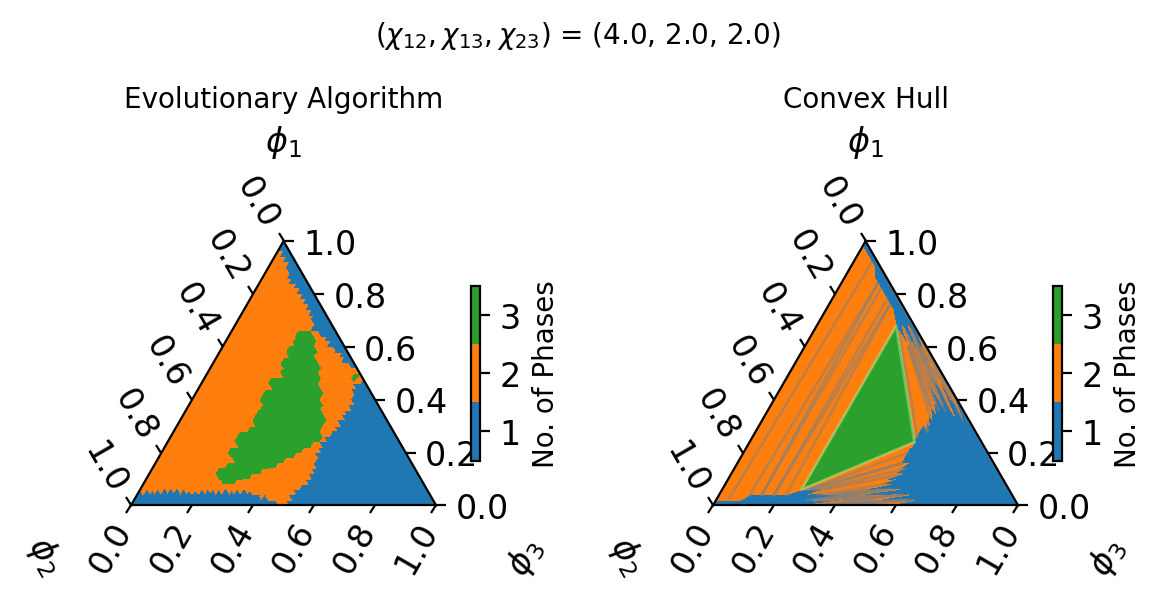

In [8]:
n = 51

num_comp = 3
chi = np.asarray([[0.0, 4.0, 2], [4.0, 0.0, 2], [2, 2, 0]])

# EVOLUTIONARY ALGORITHM
options = {
    "num_part": 8, # number of partitions
    "progress": False, # Show a progress bar from 
    "max_steps": 1000000,  # disable progress bar, allow more steps
}
# phis, slns = evo.scan_phase_space(num_comp, chi, n=n, verbose=False, options=options) # Serial processing
phis, slns = evo.scan_phase_space_pl(num_comp, chi, n=n, options=options) # Parallel processing

# CONVEX HULL
pts, nPhases, indices = ch.scan_phase_space(num_comp, chi, n=51)

fig, ax11 = evo.plot_ternary_phase_diagram(phis, slns, subplot=121)
fig, ax12 = ch.plot_ternary_phase_diagram(pts, nPhases, indices, chi=chi,  showTieLines=True,
                                        fignum=1, figsize=(6, 6), subplot=122,
                                        colorTieLines='gray', linewidth=1, nTieLines=100)
ax11.set_title("Evolutionary Algorithm", fontsize=10)
ax12.set_title("Convex Hull", fontsize=10)

fig.tight_layout()
graph.suptitle('($\chi_{12}, \chi_{13}, \chi_{23}$) = (' + 
               f'{chi[0, 1]:.1f}, {chi[0, 2]:.1f}, {chi[1, 2]:.1f})',
               rect=[0, 0.03, 1, 1.4], fontsize=10) 

# Save
# graph.save('../figures/ternary_phase_diagram/chi_4_2_2', ext=['png'], overwrite=False)


## Divide and conquer- evolutionary algorithm

## Visualize a simulation result

(21, 3)

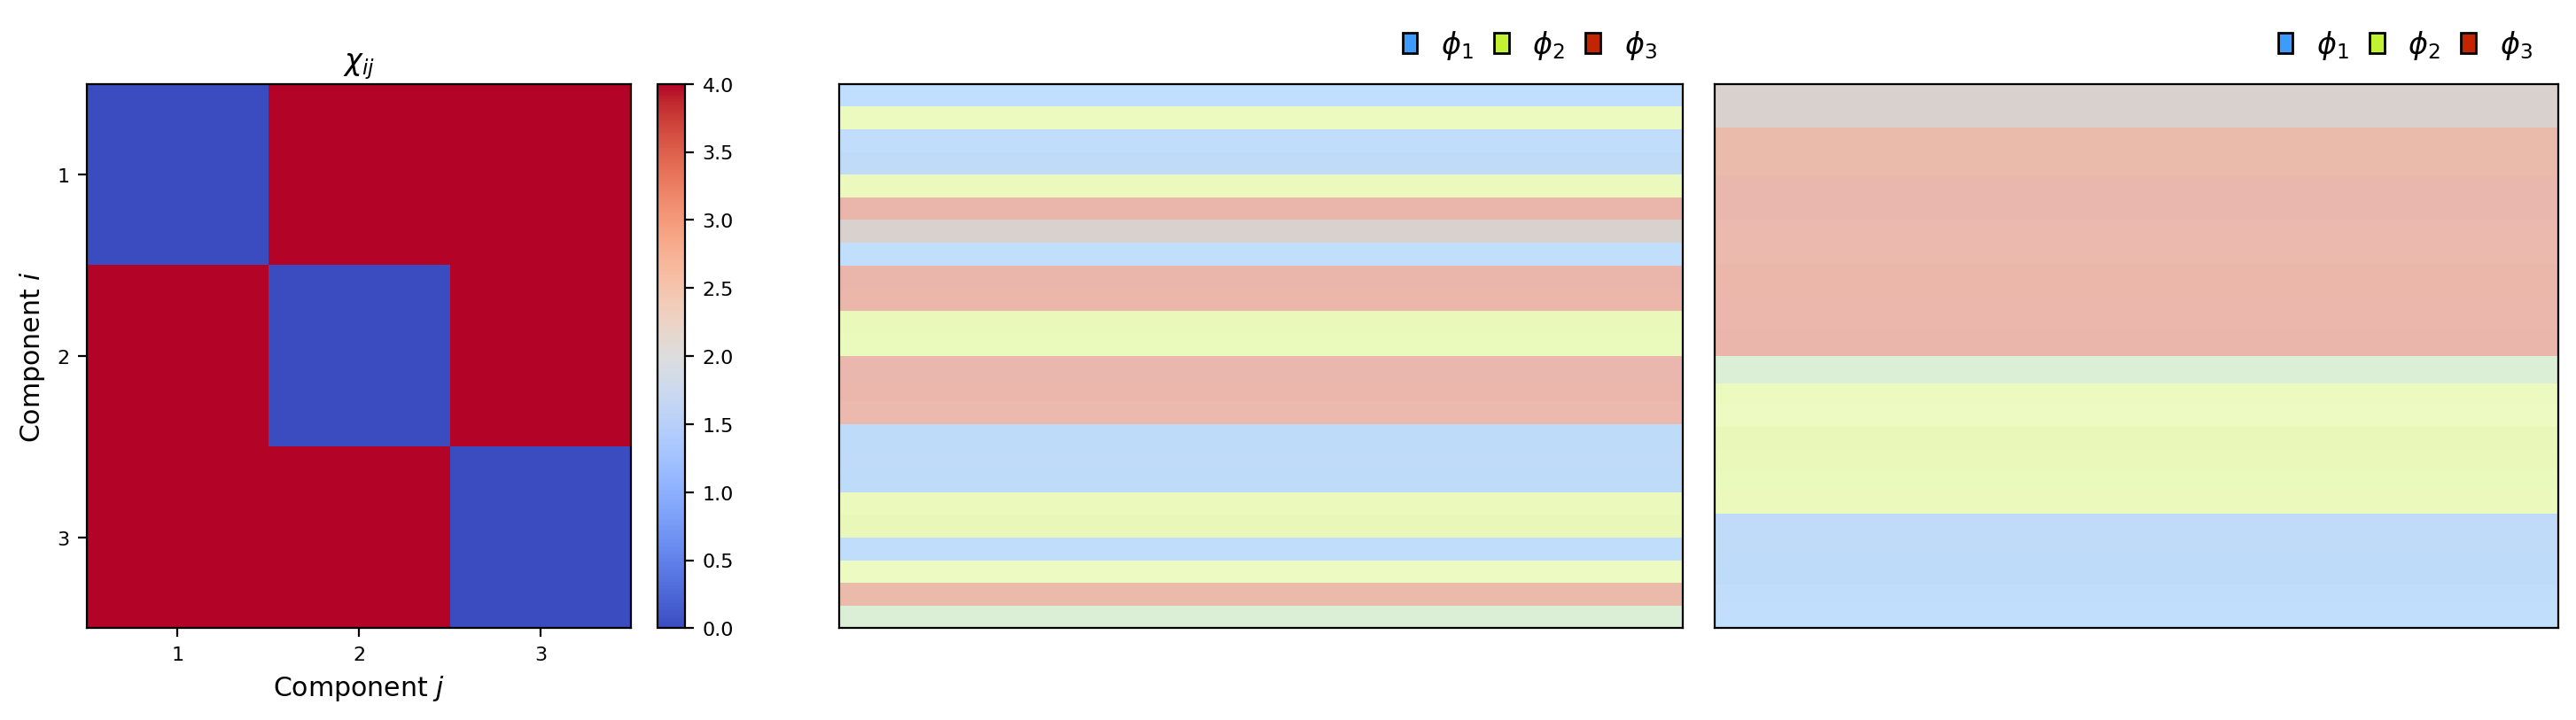

In [14]:
num_comp = 3 # Number of Components
chi12, chi13, chi23 = 4., 4., 4. # Off-diagonal 
chi = np.asarray([[0.0, chi12, chi13], [chi12, 0.0, chi23], [chi13, chi23, 0]])
options = {
    "num_part": 24,
    "progress": False,
    "max_steps": 1600,  # disable progress bar, allow more steps
}

# Initial guess
phi_i = np.ones(num_comp) / num_comp
# phi_i = np.asarray([0.59453624, 0.23951581, 0.16594796])


# Develop a faster way to scan the phase space using the divide and conquer approach
# Divide and conquer
res, sim = evo.process_phi(phi_i, chi, 
                      options=options,
                      return_finder=True
                      )
phi_f = res.fractions # Final composition of M phases, shape: (nPhases, nComp)
phis_f = evo.phase2phis(res) # (nComp, nPart) array of volume fractions

fig, ax, basis_colors = graph.visualize_mixtures([sim._phis_comp, phis_f],
                                                # height=1, width=1, 
                                                cmap='turbo', vmin=0.2, vmax=0.9,
                                                solvent_color='white', chi=chi)

phi_f.shape # Final composition of M phases

Step 0 / 150
Step 1: A mixed phase. Set the next composition randomly.
Step 9: Simulation returned more phases than the number of components. Take a random composition and continue.
Step 10: A mixed phase. Set the next composition randomly.
Step 12: A mixed phase. Set the next composition randomly.
Step 20: A mixed phase. Set the next composition randomly.
Step 25 / 150
Step 26: Reached the edge or more than one component of phi_i contain zero or negative values. Next composition will be random.
Step 28: A mixed phase. Set the next composition randomly.
Step 29: A mixed phase. Set the next composition randomly.
Step 33: A mixed phase. Set the next composition randomly.
Step 34: A mixed phase. Set the next composition randomly.
Step 35: A mixed phase. Set the next composition randomly.
Step 37: Simulation returned more phases than the number of components. Take a random composition and continue.
Step 40: A mixed phase. Set the next composition randomly.
Step 41: A mixed phase. Set the n

(3, 187)

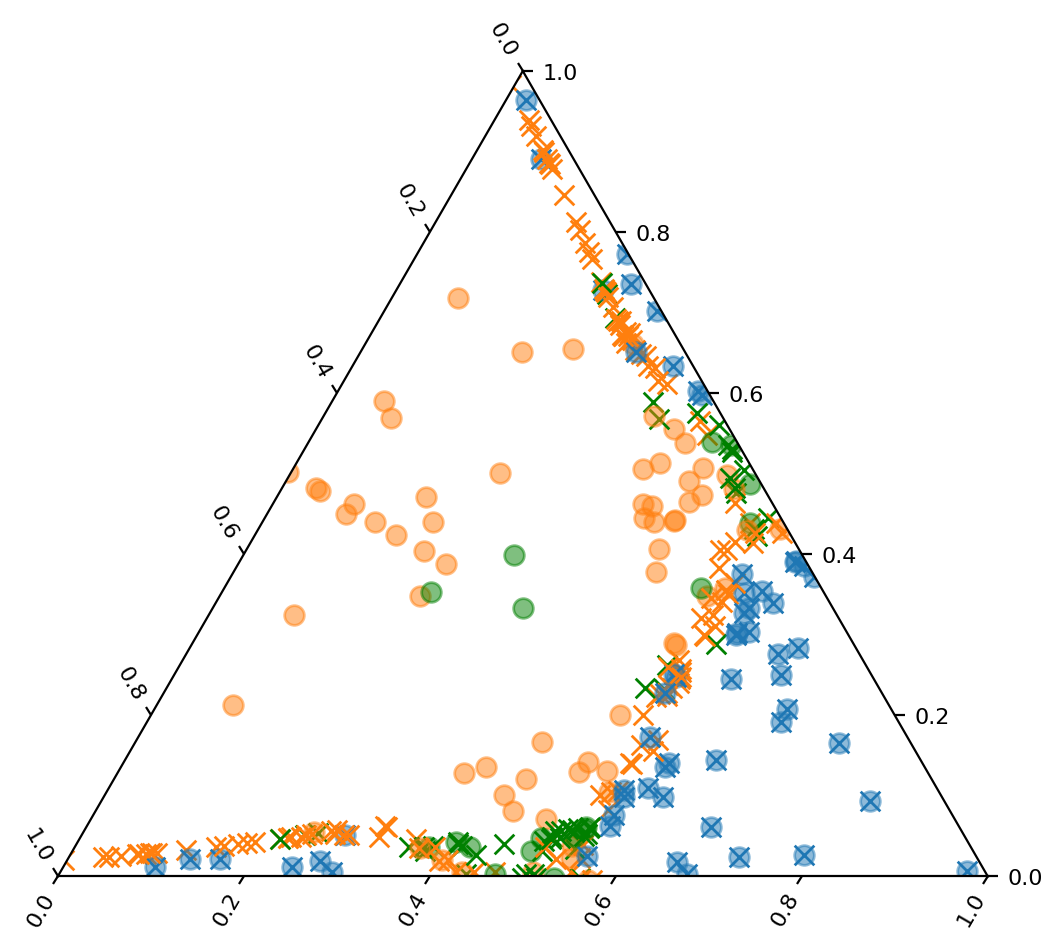

In [112]:
reload(evo)
reload(vec)
reload(geom)

np.set_printoptions(precision=3)


num_comp = 3
chi12, chi13, chi23 = 4., 2., 2.
chi = np.asarray([[0.0, chi12, chi13], [chi12, 0.0, chi23], [chi13, chi23, 0]])
options = {
    "num_part": 12,
    "progress": False,
    "max_steps": 100000,  # 10000000,  disable progress bar, allow more steps
}

def isPhiOutsideExploredRegion_CH(phi, phi_explored):
    """
    Determine if phi is in the triangle specified by explored

    Parameters
    ----------
    phi : np.ndarray
        Composition of the mixture
    explored_pts : np.ndarray, shape (nComp, nPts)
    """
    num_comp = phi.shape[0]
    if len(phi_explored) < num_comp:
        return True
    else:    
        # Points that define the explored region
        ## pts.shape = (nDim=num_comp-1, nPoints). '-1' because of the constraint \sum_i phi_i = 1
        pts = phi_explored.copy()[:num_comp-1, :] # (nDim=num_comp-1, nPoints) 

        # Concatenate the new composition to the points
        pts_new = np.concatenate((pts, phi[:num_comp-1, np.newaxis]), axis=1) # (nDim=num_comp-1, nPoints)

        # Convex hull of the new points
        ch = ConvexHull(pts_new.T) # CH accepts points in the form (nPoints, nDim)

        # Number of vertices of the convex hull
        nAfter = len(ch.vertices)
        nBefore = pts.shape[1]

        # If the number of vertices of the convex hull increases, 
        # then the new composition is outside the previously explored region
        if nAfter > nBefore:
            return True
        else:
             return False

def isPhiOutsideExploredRegion(phi, phi_explored):
    """
    Determine if phi is in the triangle specified by explored
    ... Currently limited to 3-component system. (2D winding number)
    
    Parameters
    ----------
    phi : np.ndarray
        Composition of the mixture
    explored_pts : np.ndarray, shape (nComp, nPts)
    """
    num_comp = len(phi)
    
    if len(phi_explored) < num_comp:
        return True
    else:
        # Reorder the points # This convexifies the region defined by the phi_explored for 99% of the cases
        ordered_pts = geom.connect_phis(phi_explored, close=True)
        
        x, y = phi[:2]
        polygon = ordered_pts[:2, :]
        num_vertices = polygon.shape[1]
        winding_number = 0
    
        # Loop through each edge of the polygon
        for i in range(num_vertices):
            x1, y1 = polygon[:, i]
            x2, y2 = polygon[:, (i + 1) % num_vertices]  # Next vertex, with wrap-around to the start
    
            if y1 <= y:
                if y2 > y:  # Upward crossing
                    if (x2 - x1) * (y - y1) - (x - x1) * (y2 - y1) > 0:
                        winding_number += 1
            else:
                if y2 <= y:  # Downward crossing
                    if (x2 - x1) * (y - y1) - (x - x1) * (y2 - y1) < 0:
                        winding_number -= 1
        return winding_number == 0

        
def get_next_phi_random(num_comp, phi_explored, count=1, max_count=1000):
    if count > max_count:
        print('get_next_phi_random: A maximum count reached. Cannot find a composition outside the explored region. Return None.')
        return None
    phi_next = np.random.random(num_comp)
    phi_next /= np.sum(phi_next)
    if phi_explored is None:
        return phi_next
    else:
        if all([isPhiOutsideExploredRegion(phi_next, explored) for explored in phi_explored]):
            return phi_next
        else:
            return get_next_phi_random(num_comp, phi_explored)
        
def update_explored_region(phis, phis_explored, nPhases_explored, isPhiRandom=False, connect=True):
    """
    Update the region explored
    
    Parameters
    ----------
    phis: np.ndarray, shape (nComp, nPhases)
    phis_explored: list of np.ndarray, [phase boundary 1, phase boundary 2, ...]
        ... `phase boundary 1` has shape (nComp, nPhases * nPoints) 

    Returns
    -------
    phis_explored
    nPhases_explored
    """
    nPhase = phis.shape[1]
    if phis_explored is None: # First time
        phaseChanged = False
        phis_explored = [phis]
        nPhases_explored = [np.asarray([nPhase] * nPhase)]
    else: # Subsequent times
        phaseChanged = nPhase != nPhases_explored[-1][0] # Current phase != Previous phase
        if phaseChanged or isPhiRandom:
            phis_explored.append(phis)
            nPhases_explored.append(np.asarray([nPhase] * nPhase))
        else:
            phis_explored[-1] = np.concatenate((phis_explored[-1], phis), axis=1)
            nPhases_explored[-1] = np.concatenate((nPhases_explored[-1], np.asarray([nPhase] * nPhase)))
    if connect:        
        # BOTTLENECK- connecting the explored regions every time is costly!
        # Connect the explored regions, used to identify if the next composition is inside the explored region
        merged_phis = merge_phis_explored(phis_explored)
        merged_nPhases = merge_nPhases_explored(nPhases_explored)
        conencted_phis = geom.connect_phis(merged_phis[:, merged_nPhases != 1], close=True)
        return phis_explored, nPhases_explored, phaseChanged, conencted_phis
    else:
        return phis_explored, nPhases_explored, phaseChanged, None

def get_next_phi(phi_i_log, phi_f, phis_explored, step=0.1, count=1):
    nComp, nPhase = phi_f.shape # (nComp, nPhase)
    N = nComp - 1 # Dimension of the phase space, Maximum dimension of Critical Domain (Triangle for Ternary system)
    k = nPhase - 1 # Degree of Face (k-face) of the N-polytope
    if N == k: # Complete phase-separation (nPhase = nComp)
        # Use a normal to facets of the N-polytope
        phi_next, isPhiNextRandom = get_next_phi_complete_separation(phi_i_log, phi_f, phis_explored, step=min(step, 0.01) )
    elif k < N and k > 0: # Intermediate phase-separation
        phi_next, isPhiNextRandom = get_next_phi_interm_separation(phi_i_log, phi_f, phis_explored, step=step)
    else:
        print(f'Step {count}: A mixed phase. Set the next composition randomly.' )
        phi_next = get_next_phi_random(num_comp, phis_explored)
        isPhiNextRandom = True
    return phi_next, isPhiNextRandom

def get_next_phi_complete_separation(phi_i_log, phi_f, phis_explored, step=0.1):
    # COMPLETE PHASE SEPARATION: nComp = nPhase
    nComp, nPhase = phi_f.shape # (nComp, nPhase)
    N = nComp - 1 # Dimension of the phase space, Maximum dimension of Critical Domain (Triangle for Ternary system)
    kmax = nPhase - 1 # Degree of Face (k-face) of the N-polytope
    k = N - 2  # Grab `Ridges` of the N-polytope 

    # STEP 1: Get the facets (N-1)-faces of the N-polytope.
    kFaces, centroids, normals = geom.get_k_faces(phi_f, k)
    nFacets = len(kFaces)
    
    # STEP 2: Pick a facet randomly to go off from.
    idx = np.random.randint(nFacets)
    
    # STEP 3: Set the next composition as the facet's centroid + step * normal
    phi_next = centroids[idx] + step * normals[idx][:, 0] # normals[idx][-1] is the normal towards outside the N-polytope
    
    # STEP 4: Normalize the composition 
    phi_next = phi_next / np.sum(phi_next)
    
    # STEP 5: Check if the new composition is inside the explored region
    # Already explored? 
    # Increase the step size, and try again. 
    # There's a good chance that a different edge will be selected next time.
    # Even if it doesn't work, the increasing step size will eventually force the composition to be outside the available phase space. This triggers a random composition in the unexplored region.
    if all([isPhiOutsideExploredRegion(phi_next, explored) for explored in phis_explored]):
        isPhiNextRandom = False
        return phi_next, isPhiNextRandom
    else:
        isPhiNextRandom = True
        # return get_next_phi_complete_separation(phi_i_log, phi_f, phis_explored, step=1.1*step)
        return get_next_phi_random(nComp, phis_explored), isPhiNextRandom
        
def get_next_phi_interm_separation(phi_i_log, phi_f, phis_explored, step=0.1):
    # INTERMEDIATE PHASE SEPARATION: nComp > nPhase
    nComp, nPhase = phi_f.shape # (nComp, nPhase)
    N = nComp - 1 # Dimension of the phase space
    k = kmax = nPhase - 1 # Degree of Face (k-face) of the N-polytope. Grab `Facets` of the N-polytope
    
    if N == k:
        print('get_next_phi_interm_separation: N == k.', 'Use get_next_phi_complete_separation instead.')
        return get_next_phi_complete_separation(phi_i_log, phi_f, phis_explored, step=step)
    if len(phi_i_log) < 2:
        phi_i_log = [np.random.random(nComp)] + phi_i_log
    phi0_avg = phi_i_log[-2]
    phi1_avg = phi_i_log[-1]
    
    dist_vec = phi1_avg - phi0_avg # Vector from the initial composition to the final composition
    
    kFaces, centroids, normals = geom.get_k_faces(phi_f, k) # Grab k-faces but not the facets (k != N - 1)
    nFaces = len(kFaces)
    nNormalDirections = N - k # Number of normal directions to the k-face 
    
    # STEP 2: Pick a k-face randomly to go off from.
    idx = np.random.randint(nFaces)
    
    # STEP 3: Pick a direction randomly to go off from.
    idx_normal = np.random.randint(nNormalDirections)
    
    # STEP 4: Set the normal
    normal = normals[idx][:, idx_normal]
    
    # STEP 5: Check if the normal vector is pointing in the right direction
    if np.dot(dist_vec, normal) < 0:
        normal = -normal
    
    # STEP 6: Set the next composition as the edge centroid + step * normal
    phi_next = centroids[idx] + step * normal
    
    # STEP 7: Normalize the composition 
    phi_next = phi_next / np.sum(phi_next)
    
    # STEP 8: Check if the new composition is inside the explored region
    if all([isPhiOutsideExploredRegion(phi_next, explored) for explored in phis_explored]):
        isPhiNextRandom = False
        return phi_next, isPhiNextRandom
    else:
        isPhiNextRandom = True
        # return get_next_phi_interm_separation(phi_i_log, phi_f, phis_explored, step=1.1*step)
        return get_next_phi_random(nComp, phis_explored), isPhiNextRandom

## HELPERS
def merge_phis_explored(phis_explored):
    """
    Flatten a list of arrays into a 1D array
    """
    phis_all = np.empty((3, 0))
    for phis in phis_explored:
        phis_all = np.concatenate((phis_all, phis), axis=1)
    
    return phis_all

def merge_nPhases_explored(nPhases_explored):
    """
    Flatten a list of arrays into a 1D array
    """
    nPhases_all = np.empty((0))
    for nPhases in nPhases_explored:
        nPhases_all = np.concatenate((nPhases_all, nPhases), axis=0)
    nPhases_all = nPhases_all.astype(int)
    return nPhases_all

def group_phis_explored(phis_explored, nPhases_explored):
    """
    Group the compositions by the number of phases
    """
    indices = np.arange(len(nPhases_explored))
    phis, nPhases = merge_phis_explored(phis_explored), merge_nPhases(nPhases_explored)
    
    keys = np.unique(nPhases) # 1., 2., 3., etc.
    groups = {key: np.squeeze(np.where(np.isclose(nPhases, key) ) ) for key in keys}
    
    phi_groups = {key: phis[:, indices] for key, indices in groups.items()}
    
    
    return phi_groups


# MAIN
# To be deleted
fig, ax = graph.set_fig(1, figsize=(6, 6), projection='ternary')

phis_explored = None

# Initial guess
phi_i = np.ones(num_comp) / num_comp
# phi_i = np.asarray([0.59453624, 0.23951581, 0.16594796])

def divide_and_conquer(phi_i, chi, phis_explored=None, nPhases_explored=None, conencted_phis=None, phi_i_log=None,
                       step=0.1, count=None, maxcount=50, isPhiRandom=False):
    """
    Divide and conquer to explore the phase space
    
    Parameters
    ----------
    phi_i: np.ndarray, shape (nComp,), initial composition of the mixture
    chi: np.ndarray, shape (nComp, nComp), Flory-Huggins interaction parameters
    phis_explored: list of np.ndarray, [phase boundary 1, phase boundary 2, ...]
    nPhases_explored: list of np.ndarray, [nPhases 1, nPhases 2, ...]
    conencted_phis: np.ndarray, shape (nComp, nPoints), connected points of the explored region
    phi_i_log: list of np.ndarray, shape (nComp, nComp), log of compositions
    step: float, step size to move along the normal, determining the coarseness of the exploration
    count: int, count of the recursion, keep track of the number of times this function is called
    maxcount: int, maximum count of the recursion, terminate the recursion if the count exceeds this value
    isPhiRandom: 

    Returns
    -------

    """
    def update_phi_i_log(phi_i, phi_i_log):
        if phi_i_log is None:
            phi_i_log = [phi_i, phi_i] # The first element is dummy
        else:
            phi_i_log.append(phi_i)
        return phi_i_log

    # Count how many times this function is called
    if count is None and phi_i_log is None:
        count = 0
    else:
        count = len(phi_i_log) - 1
        
    
    # PROCESS INDICATOR
    if count % 25 ==0:
        print(f'Step {count} / {maxcount}')

    
    # Format phi_i, and update phi_i_log
    phi_i = np.asarray(phi_i)
    phi_i_log = update_phi_i_log(phi_i, phi_i_log)
    
    # Step 1-1: Run a simulation
    res, sim = evo.process_phi(phi_i, chi, 
                          options=options,
                          return_finder=True
                          )
    phi_f = res.fractions.T # Final composition of M phases, shape (nComp, nPhases)
    phis_f = evo.phase2phis(res) # (nComp, nPart) array of volume fractions
    
    if len(phi_f.shape) == 1:
        phi_f = phi_f[:, np.newaxis]
    # Exception handling
    if phi_f.shape[-1] > len(phi_i):
        print(f'Step {count}: Simulation returned more phases than the number of components. Take a random composition and continue.')
        phi_next = get_next_phi_random(num_comp, [conencted_phis])
        isPhiNextRandom = True 
        res = divide_and_conquer(phi_next, chi, phis_explored, nPhases_explored, conencted_phis, 
                                     phi_i_log=phi_i_log, step=step, count=count, 
                                     maxcount=maxcount, isPhiRandom=isPhiNextRandom)
        return res
    else:
        
        # Step 1-2: # update the region explored
        phis_explored, nPhases_explored, phaseChanged, conencted_phis = update_explored_region(phi_f, phis_explored, nPhases_explored, isPhiRandom=isPhiRandom)
        # print(f'Step {count}: nPhases: {nPhases_explored[-1][0]}, Starting Composition: {phi_i}, Final avg composition: {np.nanmean(phi_f, axis=1)}, connected_phis: {conencted_phis.shape}, phis_explored[-1].shape: {phis_explored[-1].shape}')
        
    
        # STEP 1: Plot
        color = {1: 'C0', 2: 'C1', 3: 'green', 4: 'green', 5: 'green'}[phi_f.shape[-1]]
        ax.scatter(*phi_i, color=color, alpha=0.5, marker='o', s=50) # Initial composition 
        # ax.text(*phi_i, str(count), color="red", fontsize=8) # Show a step number, 'count'
        ax.scatter(phi_f[0], phi_f[1], phi_f[2], color=color, marker='x', s=50) # Final composition (Simulation result)
        
        # STEP 2: Set the next composition
        # STEP 2-1: If the current composition is at the edge of the available phase space, set the next composition randomly
        if np.any(phi_i <= 0):
            print(f'Step {count}: Reached the edge or more than one component of phi_i contain zero or negative values.', 
                         'Next composition will be random.')
            
            phi_next = get_next_phi_random(num_comp, [conencted_phis])

            # Set the boolean True to select the next Phi randomly
            isPhiNextRandom = True
        # STEP 2-2: Move along the normal if nPhase > 1: Otherwise, set the next composition randomly
        else:
            phi_next, isPhiNextRandom = get_next_phi(phi_i_log, phi_f, phis_explored, step=step, count=count)
            
        if count < maxcount:
            # Recursion step
            return divide_and_conquer(phi_next, chi, phis_explored, nPhases_explored, conencted_phis=conencted_phis,
                                     phi_i_log=phi_i_log, step=step, count=count,
                                     maxcount=maxcount, isPhiRandom=isPhiNextRandom)
        else:
            print('... A maximum step reached', count)
            return phis_explored, nPhases_explored, conencted_phis, count, phi_i_log
        return phis_explored, nPhases_explored, conencted_phis, count, phi_i_log
    
res = divide_and_conquer(phi_i, chi, maxcount=150, step=0.05)
phis_explored, nPhases_explored, conencted_phis, count, phi_i_log = res

conencted_phis.shape

0 (3, 3) 3
4 (3, 3) 3
17 (3, 3) 3
23 (3, 3) 3
33 (3, 3) 3
55 (3, 3) 3
56 (3, 3) 3
58 (3, 6) 3
69 (3, 6) 3
73 (3, 3) 3
89 (3, 3) 3
96 (3, 6) 3
98 (3, 3) 3
103 (3, 3) 3
110 (3, 3) 3


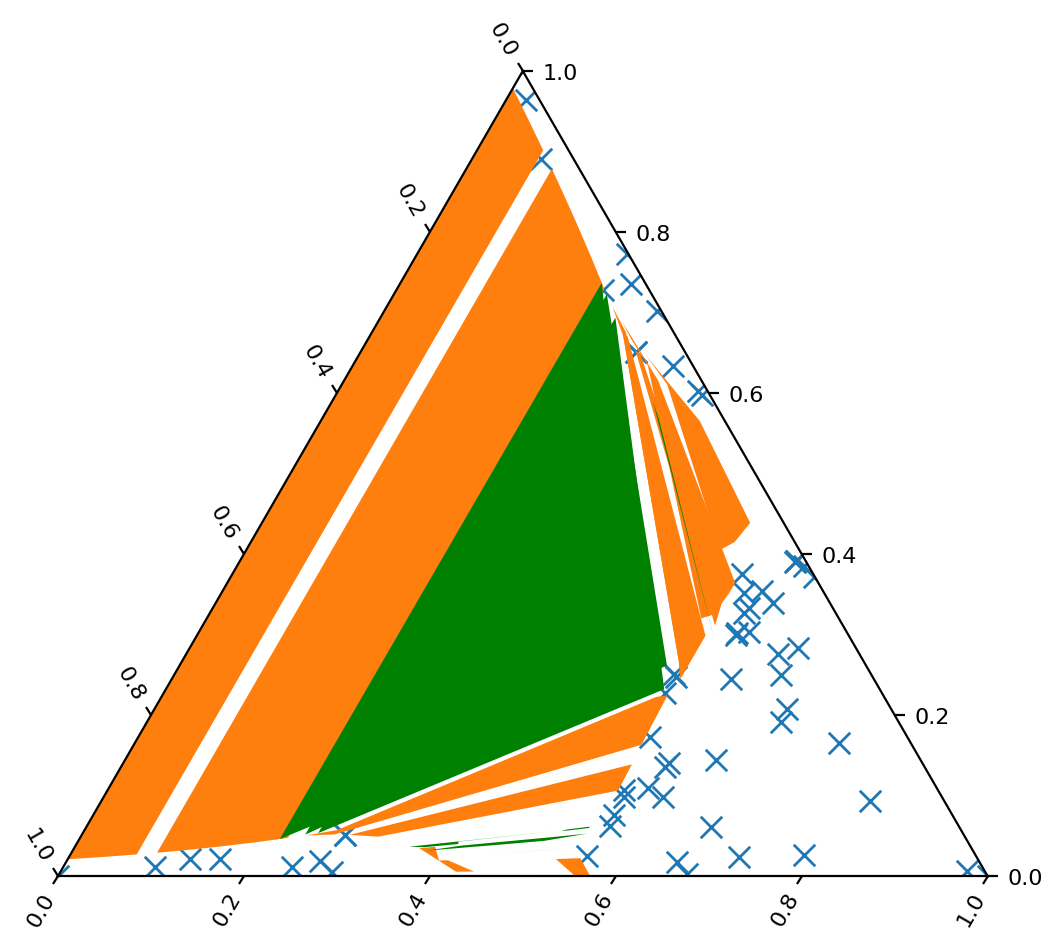

In [113]:
np.printoptions(precision=3)

import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


def merge_phis_explored(phis_explored):
    """
    Flatten a list of arrays into a 1D array
    """
    phis_all = np.empty((3, 0))
    for phis in phis_explored:
        phis_all = np.concatenate((phis_all, phis), axis=1)
    
    return phis_all

def merge_nPhases(nPhases_explored):
    """
    Flatten a list of arrays into a 1D array
    """
    nPhases_all = np.empty((0))
    for nPhases in nPhases_explored:
        nPhases_all = np.concatenate((nPhases_all, nPhases), axis=0)
    nPhases_all = nPhases_all.astype(int)
    return nPhases_all

def group_phis_explored(phis_explored, nPhases_explored):
    """
    Group the compositions by the number of phases
    """
    indices = np.arange(len(nPhases_explored))
    phis, nPhases = merge_phis_explored(phis_explored), merge_nPhases(nPhases_explored)
    
    keys = np.unique(nPhases) # 1., 2., 3., etc.
    groups = {key: np.squeeze(np.where(np.isclose(nPhases, key) ) ) for key in keys}
    
    phi_groups = {key: phis[:, indices] for key, indices in groups.items()}
    
    
    return phi_groups

def add_vetices_to_phi_and_nPhases_log(phis_explored, nPhases_explored):
    nComp = phis_explored[0].shape[0]
    vertices = np.eye(nComp)
    for i in range(nComp):
        phis = vertices[:, i:i+1]
        nPhases = np.asarray([1])
        phis_explored, nPhases_explored, _, _ = update_explored_region(phis, phis_explored, nPhases_explored, isPhiRandom=True, connect=False)
    return phis_explored, nPhases_explored

def clustering_one_phase(phis_explored, nPhases_explored, eps=0.2, min_samples=3, add_vertices=True):
    if add_vertices:
        phis_explored, nPhases_explored, _, _ = add_vetices_to_phi_and_nPhases_log(phis_explored, nPhases_explored, connect=False)
        
    merged_phis = merge_phis_explored(phis_explored)
    merged_nPhases = merge_nPhases(nPhases_explored)    
    
    # Create and fit the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    X = merged_phis[:-1, merged_nPhases==1].T
    labels = dbscan.fit_predict(X)
    
    phi_clusters = {i: merged_phis[:, merged_nPhases==1][:, labels == i] for i in np.unique(labels)}
    return phi_clusters

phis_explored, nPhases_explored, connected_phis, count, phi_i_log = res
phis_explored, nPhases_explored = add_vetices_to_phi_and_nPhases_log(phis_explored, nPhases_explored)
grouped_phis = group_phis_explored(phis_explored, nPhases_explored)
# 
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': 'ternary'})
# 

## COLOR BLOCKS
p2c = {1: 'C0', 2: 'C1', 3: 'green', 4: 'green', 5: 'green'}
for i, (phis, nPhases) in enumerate(zip(phis_explored, nPhases_explored)):
    # shade the region
    for p in [2, 3]:
        if nPhases[0] == p:
            phis_ = geom.connect_phis(phis, close=True)
            # ax.fill(phis_[0, :], phis_[1, :], phis_[2, :], alpha=0.8, color=p2c[p])
            ax.fill(phis_[0, :], phis_[1, :], phis_[2, :], alpha=1, color=p2c[p], linewidth=0., zorder=nPhases[0])
    # # One-phase
    # p = 1
    # if nPhases[0] == p:
    #     ax.scatter(phis[0, :], phis[1, :], phis[2, :], alpha=1, color=p2c[p], zorder=10)

# Plot One-phase clusters (DBSCAN)
phi_clusters = clustering_one_phase(phis_explored, nPhases_explored, eps=0.2, min_samples=3, add_vertices=False)
boundaries = {key: geom.connect_phis(phi_clusters[key], close=True) for key in phi_clusters.keys()}
for key, boundary in boundaries.items():
    # ax.fill(boundary[0, :], boundary[1, :], boundary[2, :], color=p2c[1], alpha=0.8, linewidth=0.)
    ax.scatter(boundary[0, :], boundary[1, :], boundary[2, :], color=p2c[1], alpha=1, marker='x', s=60)


# Mimicing solute effect

## Start with a two-phase solution, then increase the concentration of the third species

In [259]:
reload(evo)
num_comp = 3
num_part = 24 # number of layers / partitions
chi12, chi13, chi23 = 3., 0., 1.
chi = np.asarray([[0.0, chi12, chi13], [chi12, 0.0, chi23], [chi13, chi23, 0]])
options = {
    "num_part": num_part,
    "progress": False,
    "max_steps": 16000,  # disable progress bar, allow more steps
    'random_std': 10., 
}

# Initial guess
phi1_i, phi2_i = (0.6, 0.2)
phi3_i_max = 1 - phi1_i - phi2_i
phi3_i = np.linspace(0, phi3_i_max, 11)

compositions = []
for phi3 in phi3_i:
    phi1 = (1 - phi3) / (1 + phi2_i / phi1_i)
    phi2 = 1 - phi1 - phi3
    
    phi_i = np.asarray([phi1, phi2, phi3])
    
    # Develop a faster way to scan the phase space using the divide and conquer approach
    # Divide and conquer
    res, sim = evo.process_phi(phi_i, chi, 
                          options=options,
                          return_finder=True
                          )
    phi_f = res.fractions # Final composition of M phases, shape: (nPhases, nComp)
    phis_f = evo.phase2phis(res) # (nComp, nPart) array of volume fractions
    
    fig, ax, basis_colors = graph.visualize_mixtures([sim._phis_comp, phis_f],
                                                    # height=1, width=1, 
                                                    cmap='turbo', vmin=0.2, vmax=0.9,
                                                    solvent_color='white', chi=chi)
    graph.save('./figures/solute_effect/' + f'chi_{chi12:.1f}_{chi13:.1f}_{chi23:.1f}/phi_{phi1:.2f}_{phi2:.2f}_{phi3:.2f}'.replace('.', 'p'), close=True, transparent=False)
    
    comps = np.unique(np.round(sim._phis_comp.T, decimals=2), axis=0)
    compositions.append(comps)

Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p75_0p25_0p00.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p73_0p25_0p02.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p72_0p24_0p04.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p70_0p24_0p06.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p69_0p23_0p08.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p67_0p23_0p10.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p66_0p22_0p12.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p64_0p22_0p14.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p63_0p21_0p16.png
(2, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p61_0p21_0p18.png
(3, 3)
Figure saved to figures\solute_effect\chi_3p0_0p0_1p0\phi_0p60_0p20_0p20.png
(3, 3)


0 [0.07 0.93 0.  ] [0.]
1 [0.93 0.07 0.  ] [0.]
0 [0.07 0.92 0.01] [0.01]
1 [0.9  0.07 0.02] [0.02]
0 [0.08 0.9  0.02] [0.02]
1 [0.88 0.08 0.04] [0.04]
0 [0.08 0.89 0.03] [0.03]
1 [0.85 0.08 0.07] [0.07]
0 [0.08 0.87 0.04] [0.04]
1 [0.83 0.08 0.09] [0.09]
0 [0.09 0.86 0.05] [0.05]
1 [0.8  0.09 0.11] [0.11]
0 [0.09 0.84 0.07] [0.07]
1 [0.78 0.09 0.13] [0.13]
0 [0.1  0.81 0.09] [0.09]
1 [0.76 0.09 0.15] [0.15]
0 [0.1 0.8 0.1] [0.1]
1 [0.73 0.1  0.17] [0.17]
0 [0.11 0.77 0.12] [0.12]
1 [0.12 0.76 0.12] [0.12]
2 [0.71 0.1  0.19] [0.19]
0 [0.09 0.79 0.11] [0.11]
1 [0.66 0.12 0.21] [0.21]
2 [0.67 0.12 0.21] [0.21]


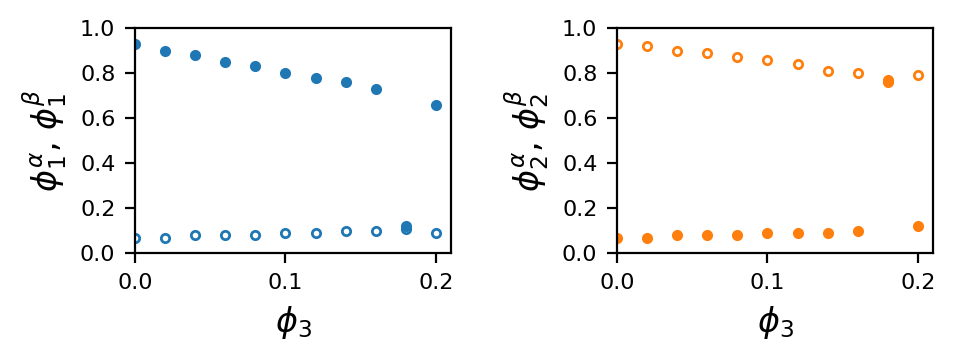

In [265]:
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(5, 2))
for i, comps in enumerate(compositions):
    for phase, comp in enumerate(comps):
        print(phase, comp, comp[2:3])
        if phase == 0: #Dense phase
            ax11.scatter(phi3_i[i], comp[0:1], color='C0', label='$\phi_1 \propto c_1$', facecolors='white')
            ax12.scatter(phi3_i[i], comp[1:2], color='C1', label='$\phi_1 \propto c_1$', facecolors='white')
        if phase == 1: # Dilute phase
            ax11.scatter(phi3_i[i], comp[0:1], color='C0', label='$\phi_1 \propto c_1$', facecolors=None)
            ax12.scatter(phi3_i[i], comp[1:2], color='C1', label='$\phi_1 \propto c_1$', facecolors=None)
        # ax.scatter(comp[2:3], comp[1:2], color='C1', label='$\phi_2 \propto c_2$')
for ax in [ax11, ax12]:

    ax.set_xlim(0, None,)
    ax.set_ylim(0, 1,)
    
    ax.set_xlabel('$\phi_3$')
ax11.set_ylabel('$\phi_1^{\\alpha}$, $\phi_1^{\\beta}$')
ax12.set_ylabel('$\phi_2^{\\alpha}$, $\phi_2^{\\beta}$')


fig.tight_layout()

# Misc

## Clustering one-phase using DBSCAN

Error in connect_dots, phi.shape (3, 5)


array([0, 1, 0, 0, 0, 2, 0, 1, 0, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1,
       3, 0, 1, 3, 0], dtype=int64)

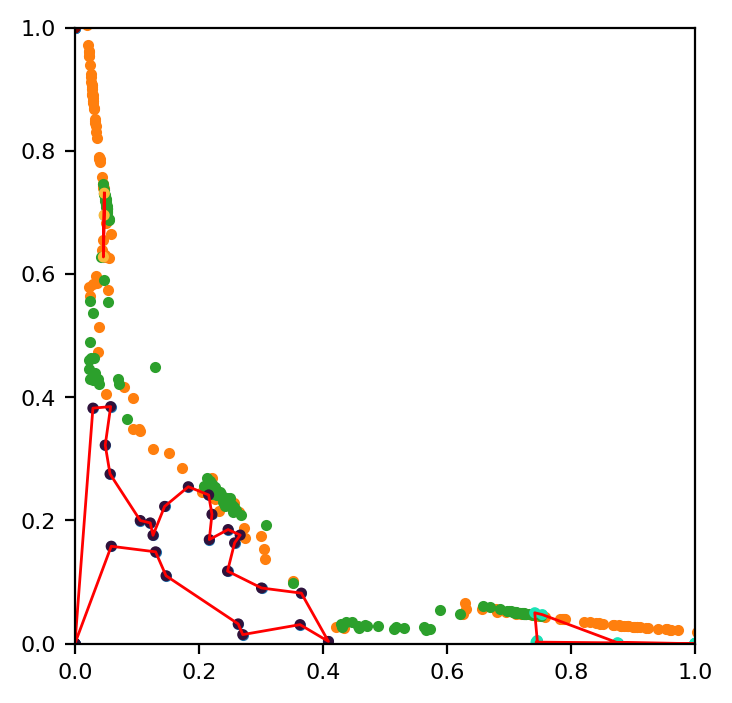

In [292]:
# connected_phis(phis, close=False)
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def clustering_one_phase(phis_explored, nPhases_explored, eps=0.2, min_samples=3, add_vertices=True):
    if add_vertices:
        phis_explored, nPhases_explored, _, _ = add_vetices_to_phi_and_nPhases_log(phis_explored, nPhases_explored, connect=False)
        
    merged_phis = merge_phis_explored(phis_explored)
    merged_nPhases = merge_nPhases(nPhases_explored)    
    
    # Create and fit the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    X = merged_phis[:-1, merged_nPhases==1].T
    labels = dbscan.fit_predict(X)
    
    phi_clusters = {i: merged_phis[:, merged_nPhases==1][:, labels == i] for i in np.unique(labels)}
    return phi_clusters


    
    

merged_phis = merge_phis_explored(phis_explored)
merged_nPhases = merge_nPhases(nPhases_explored)

plt.scatter(merged_phis[0, merged_nPhases==1], merged_phis[1, merged_nPhases==1])

plt.scatter(merged_phis[0, merged_nPhases==2], merged_phis[1, merged_nPhases==2])

plt.scatter(merged_phis[0, merged_nPhases==3], merged_phis[1, merged_nPhases==3])

plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 1)

# Generate some sample data

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=0.2, min_samples=3)
X = merged_phis[:-1, merged_nPhases==1].T
labels = dbscan.fit_predict(X)

# # Plot the data points and cluster labels
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='turbo', marker='o')

phi_clusters = clustering_one_phase(phis_explored, nPhases_explored, eps=0.2, min_samples=3, add_vertices=False)
boundaries = {key: geom.connect_phis(phi_clusters[key], close=True) for key in phi_clusters.keys()}
for key, boundary in boundaries.items():
    plt.plot(boundary[0, :], boundary[1, :], color='r')

labels

## Finding a convex hull

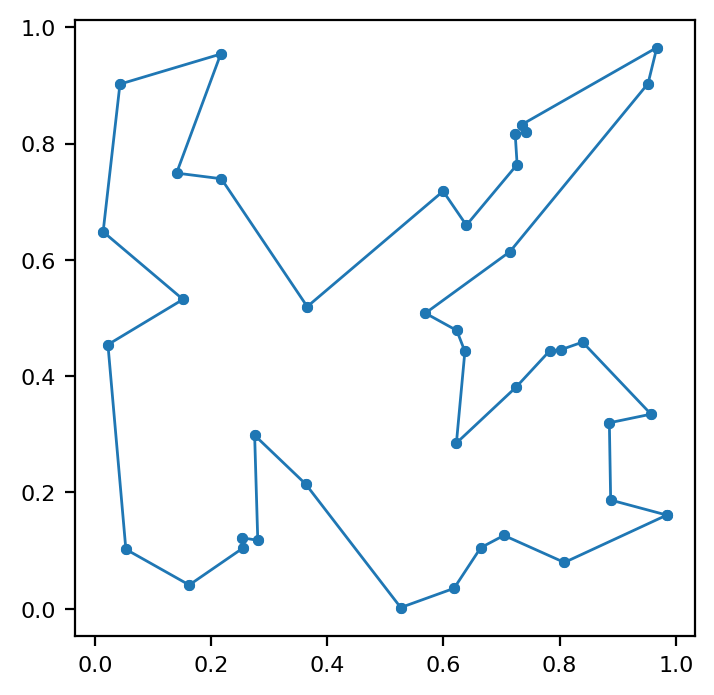

In [271]:
import alps.geometry as geom
# Generate or use your set of N-dimensional points (N_points x N_dim)
N_points = 41
N_dim = 2 # Change this to any dimension
points = np.random.rand(N_points, N_dim)

ordered_points = geom.connect_dots(points)
plt.scatter(points[:, 0], points[:, 1], )
plt.plot(ordered_points[:, 0], ordered_points[:, 1], 'o-')

In [49]:
import numpy as np
from sympy import Matrix

def get_normal(points):
    """
    Returns a normal vector to the hyperplane defined by the points. Applicable to N-dimensional space.
    
    ... points: (nComp, nPoints), points = (\vec{p1}, \vec{p2}, ..., \vec{pN})
        where \vec{p1} = (x1, x2, ..., xN) is a point in N-dimensional space.
    ... augmented matrrix 
                A = (e1, e2, ..., eN, 1)
                    (  \vec{p1}^T   , 1)
                    (  \vec{p2}^T   , 1) 
                    (     ...       , 1) 
                    (  \vec{pN}^T   , 1)        
    ... normal vector = det(A)   

    Parameters:
    points (numpy.ndarray): A numpy array of shape (N, NumPoints = N), where N is the number of dimensions.
    ... points must be linearly independent. 

    Returns:
    numpy.ndarray: A normal vector to the hyperplane.
    """
    # Check that the input is valid
    if points.shape[1] != points.shape[0]:
        raise ValueError("The number of points must be equal to the number of dimensions.")

    # Create an augmented matrix with basis vectors and the points
    augmented_matrix = np.zeros((points.shape[0] + 1, points.shape[0] + 1), dtype=object)

    # Fill the first row with basis vector symbols
    for i in range(points.shape[0]):
        augmented_matrix[0, i] = f'e{i+1}'
    augmented_matrix[:, -1] = 1
    # Fill the remaining rows with the points and an appended 1
    augmented_matrix[1:, :-1] = points.T
    
    # Calculate the determinant symbolically
    det = Matrix(augmented_matrix).det()
    
    # Convert determinant to a numpy array
    normal = np.array([det.coeff(f'e{i+1}') for i in range(points.shape[0])])
    return normal

# Example usage
# For a 3D space (N=3), we need 3 points (N=3) in 3D
points = np.array([
    [1.0, 2.0, 3.],  # x-coordinates
    [4.0, 6.0, 5.],  # y-coordinates
    [5.0, -1.0, 2.], # z-coordinates
    # [1.0, 2.0],  # x-coordinates
    # [4.0, 6.0],  # y-coordinates
])
print(points[:, 0])
normal = get_normal(points)
d = points[:, 1] - points[:, 0]
print("Normal vector (as symbolic determinant):", normal)

# dot the normal vector with a point on the plane to get the equation of the plane
points.shape # nComp, nPoints
points[:, 0]
np.dot(normal, d), points


[1. 4. 5.]
Normal vector (as symbolic determinant): [0 -9.00000000000000 -3.00000000000000]


(0,
 array([[ 1.,  2.,  3.],
        [ 4.,  6.,  5.],
        [ 5., -1.,  2.]]))

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

device(type='cuda')

In [11]:
import numpy as np
import torch

def generalized_cross_product_2d(points):
    """
    Computes a cross product in 2D using PyTorch.

    Parameters:
    points (torch.Tensor): A tensor of shape (2, 2), representing two points in 2D space.

    Returns:
    torch.Tensor: A normal vector to the line defined by the two points.
    """
    # Check that the input is valid
    if points.shape != (2, 2):
        raise ValueError("The input must be a 2x2 tensor for 2D space.")

    # Compute the direction vector between the points
    direction_vector = points[:, 1] - points[:, 0]

    # Find the normal vector by rotating the direction vector by 90 degrees
    normal_vector = torch.tensor([-direction_vector[1], direction_vector[0]])

    return normal_vector

# Example usage
# Define two points in 2D space
points = torch.tensor([
    [1.0, 4.0],  # x-coordinates
    [2.0, 6.0]   # y-coordinates
])

normal_vector = generalized_cross_product_2d(points)
print("Normal vector:", normal_vector)

np.dot(normal_vector, points[:, 0])

Normal vector: tensor([-4.,  3.])


2.0

# Scanning phase space with evolutionary algo (brute-force)and convex hull 
- Result:
- 125 iterations, Run time: 7h 49 min, 3.76 min / iteration)


In [ ]:
# (125 iterations, Run time: 7h 49 min, 3.76 min / iteration)
num_comp = 3
chis12, chis13, chis23 = np.linspace(0, 4, 5), np.linspace(0, 4, 5), np.linspace(0, 4, 5)
for chi12, chi13, chi23 in itertools.product(chis12, chis13, chis23):
    chi = np.asarray([[0.0, chi12, chi13], [chi12, 0.0, chi23], [chi13, chi23, 0]])
    
    # EVOLUTIONARY ALGORITHM
    options = {
        "num_part": 8,
        "progress": False,
        "max_steps": 10000000,  # disable progress bar, allow more steps
    }
    # phis, slns = evo.scan_phase_space(num_comp, chi, n=101, verbose=False, options=options) # Serial version
    phis, slns = evo.scan_phase_space_pl(num_comp, chi, n=101, options=options) # Parallel version
    # CONVEX HULL
    pts, nPhases, indices = ch.scan_phase_space(num_comp, chi, n=151)
    
    fig, ax11 = evo.plot_ternary_phase_diagram(phis, slns, subplot=121)
    fig, ax12 = ch.plot_ternary_phase_diagram(pts, nPhases, indices, chi=chi,  showTieLines=True,
                                            fignum=1, figsize=(6, 6), subplot=122,
                                            colorTieLines='gray', linewidth=1, nTieLines=100)
    ax11.set_title("Evolutionary Algorithm", fontsize=10)
    ax12.set_title("Convex Hull", fontsize=10)
    
    fig.tight_layout()
    graph.suptitle('($\chi_{12}, \chi_{13}, \chi_{23}$) = (' + 
                   f'{chi[0, 1]:.1f}, {chi[0, 2]:.1f}, {chi[1, 2]:.1f})',
                   rect=[0, 0.03, 1, 1.4], fontsize=10) 
    
    graph.save(f'../figures/ternary_phase_diagram/chi_{chi12}_{chi13}_{chi23}', ext=['png', 'pdf', 'svg'], overwrite=False, close=True)


## Visualizing a mixture
Argument: 

In [24]:
# First, run a simulation
num_comp = 3
num_part = 24 # number of layers / partitions
chi12, chi13, chi23 = 3., 3., 3.5
chi = np.asarray([[0.0, chi12, chi13], [chi12, 0.0, chi23], [chi13, chi23, 0]])
options = {
    "num_part": num_part,
    "progress": False,
    "max_steps": 16000,  # disable progress bar, allow more steps
    'random_std': 10., 
}

phi_i = np.asarray([0.59453624, 0.23951581, 0.16594796])


# Develop a faster way to scan the phase space using the divide and conquer approach
# Divide and conquer
res, sim = evo.process_phi(phi_i, chi, 
                      options=options,
                      return_finder=True
                      )
# res: flory.flory.common.phases.Phases'  instance
# sim: flory.flory.mcmp.finder.CoexistingPhasesFinder instance

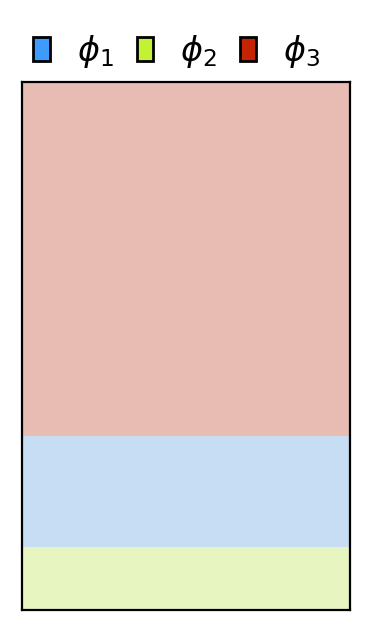

In [25]:
phis_f = evo.phase2phis(res)

fig, ax, c = graph.visualize_mixture(phis_f, height=3, width=2)
